## Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV
From: https://www.pyimagesearch.com/2020/06/22/turning-any-cnn-image-classifier-into-an-object-detector-with-keras-tensorflow-and-opencv/

In [1]:
! pip3 install imutils opencv-contrib-python
! apt install -y libgl1-mesa-glx

     |████████████████████████████████| 56.3 MB 36.5 MB/s eta 0:00:01
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=d136c63fa4dd671265ed4bce6201531daacfbf379a4eb75e7269ef12b975c869
  Stored in directory: /root/.cache/pip/wheels/f5/0c/3a/61b992f7aa85de40f339e6d4970d91dddb103dd0ad6c5d58f2
Successfully built imutils
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libbsd0 libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libdrm2 libedit2 libelf1 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libllvm10 libpciaccess0 libsensors4 libx11-6
  libx11-data libx11-xcb1 libxau6 libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0
  libxcb-present0 libxcb-sync1 libxcb1 libxdamage1 libxdmcp6 libxext6
  libxfixes3 libxshmfence1 lib

7Progress: [  9%] [#####.....................................................] 8Unpacking libx11-6:amd64 (2:1.6.4-3ubuntu0.3) ...
7Progress: [ 10%] [#####.....................................................] 8Selecting previously unselected package libxext6:amd64.
Preparing to unpack .../06-libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
7Progress: [ 11%] [######....................................................] 8Selecting previously unselected package libxxf86vm1:amd64.
Preparing to unpack .../07-libxxf86vm1_1%3a1.1.4-1_amd64.deb ...
7Progress: [ 13%] [#######...................................................] 8Unpacking libxxf86vm1:amd64 (1:1.1.4-1) ...
7Progress: [ 13%] [#######...................................................] 8Selecting previously unselected package libelf1:amd64.
Preparing to unpack .../08-libelf1_0.170-0.4ubuntu0.1_amd64.deb ...
7Progress: [ 14%] [########..................................................] 8Unpackin

7Progress: [ 47%] [###########################...............................] 8Selecting previously unselected package libxdamage1:amd64.
Preparing to unpack .../28-libxdamage1_1%3a1.1.4-3_amd64.deb ...
7Progress: [ 48%] [############################..............................] 8Unpacking libxdamage1:amd64 (1:1.1.4-3) ...
7Progress: [ 49%] [############################..............................] 8Selecting previously unselected package libxfixes3:amd64.
Preparing to unpack .../29-libxfixes3_1%3a5.0.3-1_amd64.deb ...
7Progress: [ 50%] [#############################.............................] 8Unpacking libxfixes3:amd64 (1:5.0.3-1) ...
7Progress: [ 51%] [#############################.............................] 8Selecting previously unselected package libxshmfence1:amd64.
Preparing to unpack .../30-libxshmfence1_1.3-1_amd64.deb ...
Unpacking libxshmfence1:amd64 (1.3-1) ...
7Progress: [ 52%] [##############################............................] 8Selecting p

In [98]:
# import the necessary packages
import matplotlib.pyplot as plt
import imutils
import cv2

import imutils
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])
            
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image
	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)
		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break
		# yield the next image in the pyramid
		yield image

In [99]:
# import the necessary packages
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression

import numpy as np
import argparse
import imutils
import time
import cv2

# image folder
folder_path = '/tf/testing'
# path to model
model_path = '/tf/model-export/plane-detector'

In [100]:
# load our network weights from disk
print("[INFO] loading network...")
# load the trained model
model = load_model(model_path)
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)



[INFO] loading network...


In [129]:
# initialize variables used for the object detection procedure

WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 10
ROI_SIZE = (20, 20) #(200,150)
INPUT_SIZE = (299, 299)
MIN_CONF = 1
image="./sample.jpg"
VISUALIZE=False

In [130]:
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(image)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
#cv2.imshow("ROI", orig)
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

In [131]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [132]:
# loop over the image pyramid
for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        # take the ROI and preprocess it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        #roi = preprocess_input(roi)
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if VISUALIZE:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),
                (0, 255, 0), 2)
            # show the visualization and current ROI
            plt.imshow(clone)
            plt.title("Visualization")
            plt.show()
            plt.imshow(roiOrig)
            plt.title("roiOrig")
            plt.show()

In [133]:

# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))
# convert the ROIs to a NumPy array
#rois = (rois[...,::-1].astype(np.float32)) / 255.0
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(
	end - start))
# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
#preds = imagenet_utils.decode_predictions(preds, top=1)
#print(rois.shape)
#print(preds)

[INFO] looping over pyramid/windows took 4.71903 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 14.90987 seconds


In [134]:
#print(preds)
# loop over the predictions
for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    #(imagenetID, label, prob) = p[0]
    prob = p[0]
    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= MIN_CONF:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        box = locs[i]
        # grab the list of predictions for the label and add the
        # bounding box and probability to the list
        #L = labels.get(label, [])
        #L = "plane" #labels.get(label, [])
        L=[]
        L.append((box, prob))
        labels["plane"] = L
print(L)
print(labels)

[((108, 108, 192, 192), 1.0060818)]
{'plane': [((108, 108, 192, 192), 1.0060818)]}


[INFO] showing results for 'plane'
[((108, 108, 192, 192), 1.0060818)]


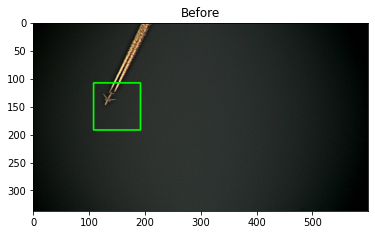

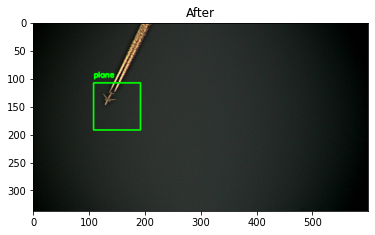

In [135]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    print(labels[label])
    clone = orig.copy()
    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    plt.imshow(clone)
    plt.title('Before')
    plt.show()
    clone = orig.copy()
    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
    plt.title('After')
    plt.show()


## Select Search approach for suggesting ROI
From: https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/

In [5]:
import random
import time
import cv2
import matplotlib.pyplot as plt
import imutils
import numpy as np

In [8]:
FAST=True
FILE_PATH="./sample.jpg"

[INFO] using *fast* selective search
[INFO] selective search took 53.0868 seconds
[INFO] 8598 total region proposals


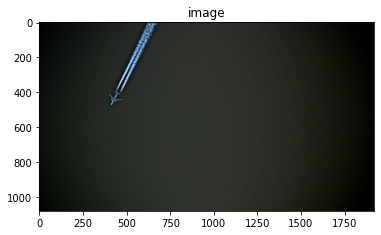

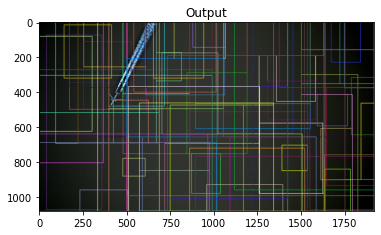

In [10]:
# load the input image
image = cv2.imread(FILE_PATH)
# initialize OpenCV's selective search implementation and set the
# input image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
# check to see if we are using the *fast* but *less accurate* version
# of selective search
if FAST:
    print("[INFO] using *fast* selective search")
    ss.switchToSelectiveSearchFast()
# otherwise we are using the *slower* but *more accurate* version
else:
    ss.switchToSelectiveSearchQuality()
    print("[INFO] using *quality* selective search")
# run selective search on the input image
start = time.time()
rects = ss.process()
end = time.time()
# show how along selective search took to run along with the total
# number of returned region proposals
print("[INFO] selective search took {:.4f} seconds".format(end - start))
print("[INFO] {} total region proposals".format(len(rects)))
plt.imshow(image)
plt.title('image')
plt.show()

# loop over the region proposals in chunks (so we can better
# visualize them)
for i in range(0, len(rects), 100):
    # clone the original image so we can draw on it
    output = image.copy()
    # loop over the current subset of region proposals
    for (x, y, w, h) in rects[i:i + 100]:
        # draw the region proposal bounding box on the image
        color = [random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)

plt.imshow(output)
plt.title('Output')
plt.show()


## Feeding ROIs to a Model

In [8]:
# import the necessary packages
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import random
import time
import cv2
import matplotlib.pyplot as plt
import imutils
import numpy as np
# image folder
folder_path = '/tf/testing'
# path to model
model_path = '/tf/model-export/plane-detector'
INPUT_SIZE = (299, 299)
MIN_CONF = 1
FAST = True
FAST=True
FILE_PATH="./sample.jpg"

In [3]:
# load our network weights from disk
print("[INFO] loading network...")
# load the trained model
model = load_model(model_path)
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)



[INFO] loading network...


In [4]:
def selective_search(image, fast):
	# initialize OpenCV's selective search implementation and set the
	# input image
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if fast:
		ss.switchToSelectiveSearchFast()
	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()
	# run selective search on the input image
	rects = ss.process()
	# return the region proposal bounding boxes
	return rects

In [9]:
# load the input image
image = cv2.imread(FILE_PATH)
(H, W) = image.shape[:2]
rects = selective_search(image, FAST)
print("[INFO] {} regions found by selective search".format(len(rects)))
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes


[INFO] 8598 regions found by selective search


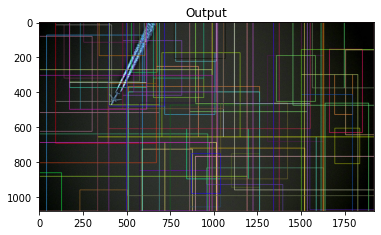

In [66]:
# loop over the region proposals in chunks (so we can better
# visualize them)
for i in range(0, len(rects), 100):
    # clone the original image so we can draw on it
    output = image.copy()
    # loop over the current subset of region proposals
    for (x, y, w, h) in rects[i:i + 100]:
        # draw the region proposal bounding box on the image
        color = [random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)

plt.imshow(output)
plt.title('Output')
plt.show()


In [31]:
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects:
    # if the width or height of the region is less than 10% of the
    # image width or height, ignore it (i.e., filter out small
    # objects that are likely false-positives)
    if w / float(W) > 0.2 or h / float(H) > 0.2:
        continue
    if w / float(W) < 0.05 or h / float(H) < 0.05:
        continue
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to 224x224 (the input
    # dimensions required by our pre-trained CNN)
    

    roi = image[y:y + h, x:x + w]
    
    # Crop, but add a border
    old_size = roi.shape[:2]
    ratio = float(299)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    roi = cv2.resize(roi, (new_size[1], new_size[0]))

    delta_w = 398 - new_size[1] # this gets us back to the original image ratio size from taining
    delta_h = 299 - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    roi = cv2.copyMakeBorder(roi, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)

    roi = cv2.resize(roi, (299, 299))

    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = img_to_array(roi)
    #roi = preprocess_input(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, w, h))

print("[INFO] {} boxes to invesitgate".format(len(boxes)))
print("[INFO] {} proposals to predict".format(len(boxes)))

[INFO] 1282 boxes to invesitgate
[INFO] 1282 proposals to predict


In [32]:
# convert the proposals list into NumPy array and show its dimensions
proposals = np.array(proposals, dtype="float32")
print("[INFO] proposal shape: {}".format(proposals.shape))
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)


[INFO] proposal shape: (1282, 299, 299, 3)
[INFO] classifying proposals...


In [33]:
#print(preds)
# loop over the predictions
print("[INFO] {} predictions".format(len(preds)))
labels = {"plane":[]}
for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    #(imagenetID, label, prob) = p[0]
    prob = p[0]
    # filter out weak detections by ensuring the predicted probability
    # is greater than the minimum probability
    if prob >= MIN_CONF:
        # grab the bounding box associated with the prediction and
        # convert the coordinates
        (x, y, w, h) = boxes[i]
        box = (x, y, x + w, y + h)
        #print(box)
        # grab the list of predictions for the label and add the
        # bounding box + probability to the list
        #L = labels.get("plane",[])
        #L.append((box, prob))
        labels["plane"].append((box, prob))
        

print("[INFO] {} predicted values".format(len(labels["plane"])))

[INFO] 1282 predictions
[INFO] 22 predicted values


[INFO] showing results for 'plane'


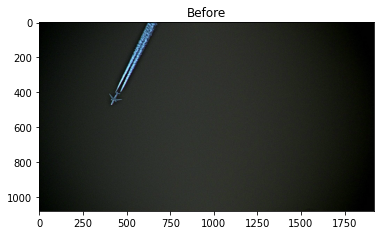

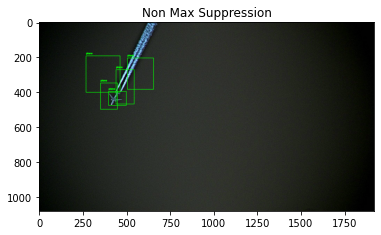

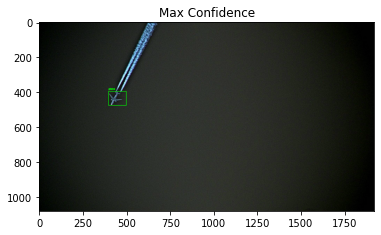

In [34]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = image.copy()
    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        if prob >5:
            (startX, startY, endX, endY) = box
            cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    plt.imshow(clone)
    plt.title('Before')
    plt.show()
    clone = image.copy()
    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    ind = np.argmax(proba)
    maxBox=boxes[ind]

    #print(boxes)
    boxes = non_max_suppression(boxes, proba)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
    plt.title('Non Max Suppression')
    plt.show()
    clone = image.copy()
    (startX, startY, endX, endY) = maxBox
    # draw the bounding box and label on the image
    cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    # show the output after apply non-maxima suppression
    plt.imshow(clone)
    plt.title('Max Confidence')
    plt.show()


In [1]:
import fiftyone as fo